In [1]:
# Add multi-core optimization for Intel Distribution for Python
import os
import tensorflow as tf
from tensorflow import keras

NUM_PARALLEL_EXEC_UNITS = 10  # for 10-core Xenon processor
config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=NUM_PARALLEL_EXEC_UNITS, 
                                  inter_op_parallelism_threads=2,
                                  allow_soft_placement=True, 
                                  device_count={'CPU': NUM_PARALLEL_EXEC_UNITS})
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)
os.environ["OMP_NUM_THREADS"] = "10" # for 10-core Xenon processor
os.environ["KMP_BLOCKTIME"] = "30"
os.environ["KMP_SETTINGS"] = "1"
os.environ["KMP_AFFINITY"] = "granularity=fine,verbose,compact,1,0"

In [2]:
# Import modules
from keras import layers
from keras import models
from keras import utils
from keras import callbacks

from keras.models import load_model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

Using TensorFlow backend.


In [3]:
## Constants

# Image Dimensions (pixels)
HEIGHT = 28
WIDTH = 28

# Train test split
TEST_SIZE = 0.15   # 85 / 15 split

# Random seed
SEED = 4242

# Batch size and number of training epochs
BATCH_SIZE = 256
EPOCHS = 5000

# Early stop parameters
PATIENCE = 25                          # Number of epochs without improvement
MIN_DELTA = 0.0001                     # Minimum change to be considered improvement
MONITOR = 'val_loss'                   # Variable being monitored
MODE = 'min'                           # Mode for monitor (minimize validation loss)
FILE_PATH = 'best_model_cnn_emnist.h5' # Path to saved model

In [4]:
# Fix numpy random seed
np.random.seed(SEED)

In [5]:
# Load data
train = pd.read_csv("/Users/patrickoceallaigh/Data/EMNIST/kaggle_csv/emnist-balanced-train.csv",
                    delimiter = ',')
test = pd.read_csv("/Users/patrickoceallaigh/Data/EMNIST/kaggle_csv/emnist-balanced-test.csv",
                   delimiter = ',')
mapp = pd.read_csv("/Users/patrickoceallaigh/Data/EMNIST/kaggle_csv/emnist-balanced-mapping.txt",
                   delimiter = ' ', index_col = 0,
                   header = None, squeeze = True)

print("Train: %s, Test: %s, Map: %s" %(train.shape, test.shape, mapp.shape))

Train: (112799, 785), Test: (18799, 785), Map: (47,)


In [6]:
# Split x and y
train_x = train.iloc[:,1:]
train_y = train.iloc[:,0]
del train

test_x = test.iloc[:,1:]
test_y = test.iloc[:,0]
del test

print(train_x.shape,train_y.shape,test_x.shape,test_y.shape)

(112799, 784) (112799,) (18799, 784) (18799,)


In [7]:
# Define function to flip and rotate image
def rotate(image):
    image = image.reshape([HEIGHT, WIDTH])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

In [8]:
# Flip and rotate image
train_x = np.asarray(train_x)
train_x = np.apply_along_axis(rotate, 1, train_x)
print ("train_x:",train_x.shape)

test_x = np.asarray(test_x)
test_x = np.apply_along_axis(rotate, 1, test_x)
print ("test_x:",test_x.shape)

train_x: (112799, 28, 28)
test_x: (18799, 28, 28)


In [9]:
# Normalise
train_x = train_x.astype('float32')
train_x /= 255
test_x = test_x.astype('float32')
test_x /= 255

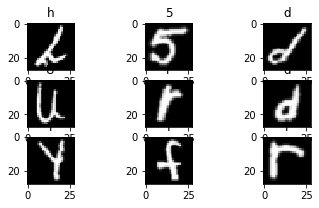

In [10]:
# Plot images
for i in range(100, 109):
    plt.subplot(330 + (i+1))
    plt.imshow(train_x[i], cmap = plt.get_cmap('gray'))
    plt.title(chr(mapp[train_y[i]]))

In [11]:
# Number of classes
num_classes = train_y.nunique()
print ("Number of Classes:", num_classes)

Number of Classes: 47


In [12]:
# One hot encoding
train_y = utils.np_utils.to_categorical(train_y, num_classes)
test_y = utils.np_utils.to_categorical(test_y, num_classes)
print("train_y: ", train_y.shape)
print("test_y: ", test_y.shape)

train_y:  (112799, 47)
test_y:  (18799, 47)


In [13]:
# Reshape image for CNN
train_x = train_x.reshape(-1, HEIGHT, WIDTH, 1)
test_x = test_x.reshape(-1, HEIGHT, WIDTH, 1)

In [14]:
# Partition to train and val
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y,
                                                  test_size = TEST_SIZE,
                                                  random_state = SEED)

In [15]:
# Build model
model = models.Sequential()

model.add(layers.Conv2D(filters = 32,
                        kernel_size = (3,3),
                        padding = 'same',
                        activation = 'relu',
                        input_shape = (HEIGHT, WIDTH,1)))
model.add(layers.MaxPooling2D(pool_size = (2,2)))
model.add(layers.Conv2D(filters = 64,
                        kernel_size = (3,3),
                        padding = 'same',
                        activation = 'relu'))
model.add(layers.MaxPooling2D(pool_size = (2,2)))
model.add(layers.Conv2D(filters = 64,
                        kernel_size = (3,3),
                        padding = 'same',
                        activation = 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(units = 64,
                       activation = 'relu'))
model.add(layers.Dropout(.5))
model.add(layers.Dense(units = num_classes,
                       activation = 'softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)              

In [16]:
# Compile model
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [17]:
# Set callback functions to stop training early and save the best model so far
keras_callbacks   = [
    callbacks.EarlyStopping(monitor = MONITOR, patience = PATIENCE,
                            mode = MODE, min_delta = MIN_DELTA, verbose = 1),
    callbacks.ModelCheckpoint(filepath = FILE_PATH, monitor = MONITOR,
                              save_best_only = True, mode = MODE, verbose = 1)
]

In [18]:
# Fit model
model_history = model.fit(train_x, train_y,
                    epochs = EPOCHS,
                    batch_size = BATCH_SIZE,
                    verbose = 1,
                    validation_data=(val_x, val_y),
                    callbacks = keras_callbacks)

Train on 95879 samples, validate on 16920 samples
Epoch 1/5000
95879/95879 [==============================] - 30s 315us/step - loss: 1.9725 - accuracy: 0.4341 - val_loss: 0.6749 - val_accuracy: 0.7816

In [20]:
# Variables - Function definition for plot accuracy
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs_plt = range(1,len(acc)+1)

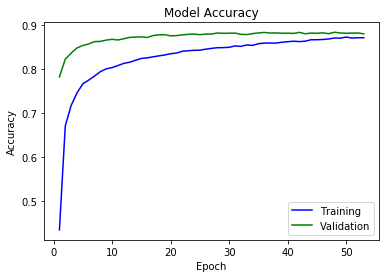

In [21]:
# Function definition for plot accuracy
def plotgraph_a(epochs_plt, acc, val_acc):
    # Plot training & validation accuracy values
    plt.plot(epochs_plt, acc, 'b')
    plt.plot(epochs_plt, val_acc, 'g')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc = 'lower right')
    plt.show()

# Accuracy curve
plotgraph_a(epochs_plt, acc, val_acc)


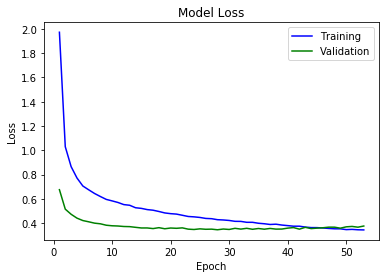

In [22]:
# Function definition for plot loss
def plotgraph_l(epochs_plt, loss, val_loss):
    # Plot training & validation loss values
    plt.plot(epochs_plt, loss, 'b')
    plt.plot(epochs_plt, val_loss, 'g')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc = 'upper right')
    plt.show()

# Loss curve
plotgraph_l(epochs_plt, loss, val_loss)

In [23]:
# Evaluate model
scores = model.evaluate(test_x, test_y, verbose=0)
print(f'Score: {model.metrics_names[0]} of {round(scores[0], 4)}; '
      f'{model.metrics_names[1]} of {round((scores[1]*100), 4)}%')

Score: loss of 0.397; accuracy of 87.9674%


In [24]:
y_pred = model.predict(test_x)
y_pred = (y_pred > 0.5)

In [26]:
# Confusion matrix (scikit-learn)
cm = metrics.confusion_matrix(test_y.argmax(axis=1), y_pred.argmax(axis=1))

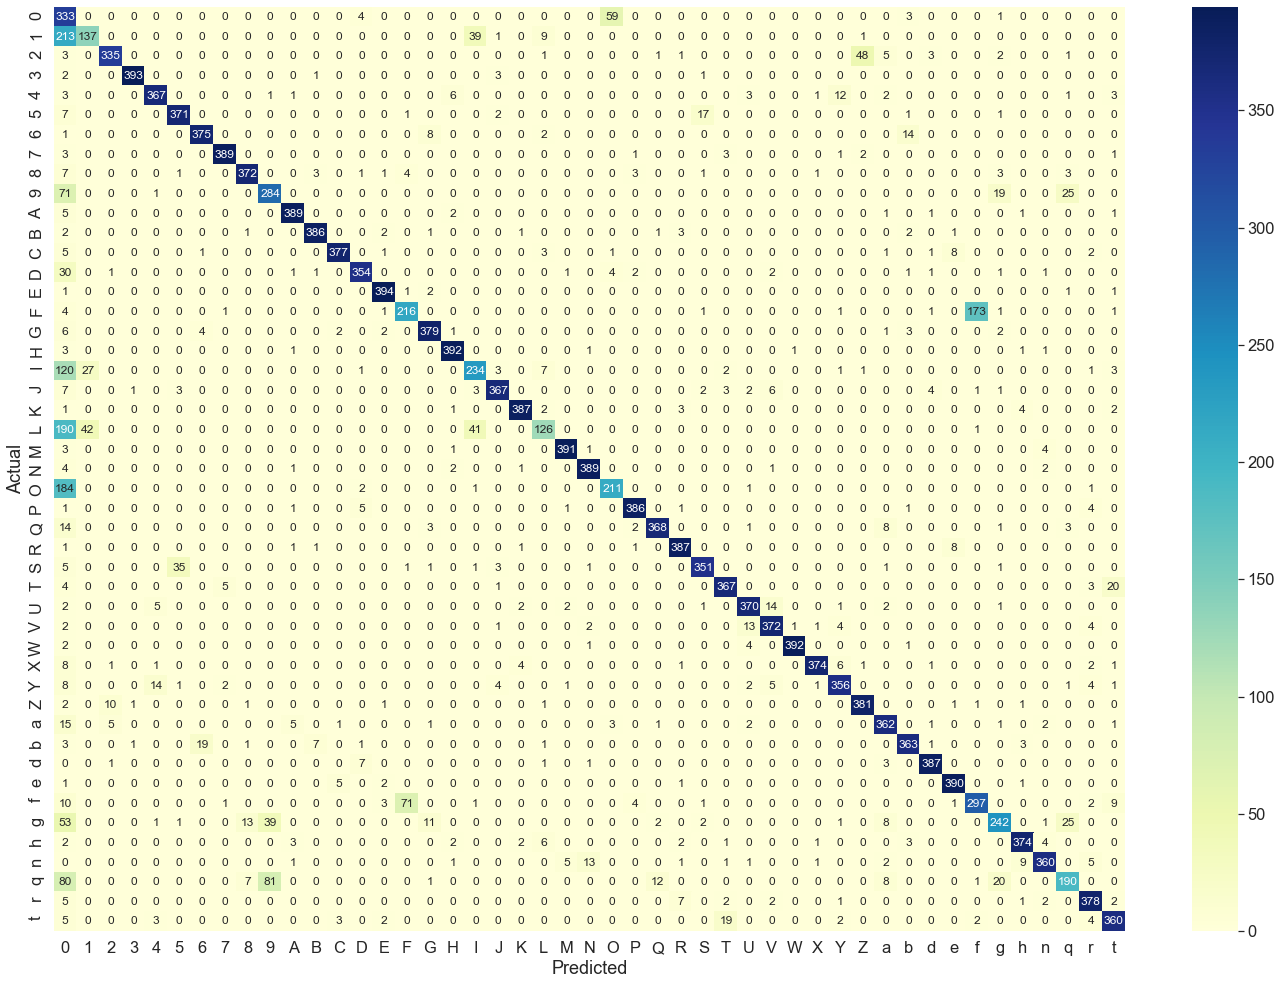

In [27]:
# Create Seaborn Heatmap for Confusion Matrix
import seaborn as sn

# Get labels from mapp series and convert to a string
labels = np.array(mapp.values, dtype=np.uint8).view('S1')
labels = labels.astype(str)
labels = pd.Series(labels)
map_labels = labels.values.tolist()

df_cm = pd.DataFrame(cm, index=labels, columns=labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (24,17))
sn.set(font_scale=1.5) # for label size
ax = sn.heatmap(df_cm, cmap="YlGnBu", annot=True, annot_kws={"size": 12}, fmt='g') # font size
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_xticklabels = map_labels
ax.set_yticklabels = map_labels
plt.show()

# Used to fix matplotlib v.3.1.1 error that cutoff top and bottom of heatmap
# ax = sn.heatmap(df_corr, annot=True) #notation: "annot" not "annote"
# bottom, top = ax.get_ylim()
# ax.set_ylim(bottom + 0.5, top - 0.5)

In [28]:
# Load the saved model
saved_model = load_model(FILE_PATH)

# Evaluate the saved model
scores = saved_model.evaluate(test_x, test_y, verbose = 1)
print(f'Score: {saved_model.metrics_names[0]} of {round(scores[0], 4)}; '
      f'{saved_model.metrics_names[1]} of {round((scores[1]*100), 4)}%')


18799/18799 [==============================] - 4s 218us/step